In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import polars as pl
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from collections import Counter
import numpy as np
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def get_train_test(df, test_size):
    # Make X and Y dataset
    y = df.observation
    print(y.unique())
    X = df.loc[:,'VH_30':'VH_0']
    X['nth'] = df.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)
    return X_train, X_test, y_train, y_test

In [3]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [4]:
kdprov='32'

In [5]:
# Parameters
kdprov = 32


In [6]:
## Read VH dataset
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/training_VH_v2.pkl','rb') as file:
    df=pickle.load(file)
    if isinstance(df, pl.DataFrame):
        df=df.to_pandas()
print(df.shape)
df.head()

(595044, 44)


,idpoint,idsubsegment,idsegment,nth,periode,observation,class,MGRS,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,idkabkota,cluster_data,Sigma0VH_variance,winner,prior
0,320201009B1#15,320201009B1,320201009,1,2022_03,2,V2,48MXS,-16.549404,-14.999514,...,-18.853233,-17.381054,-18.202223,-16.116438,-16.160796,3202,4,0.344137,R4C7,0.424818
1,320201009B2#01,320201009B2,320201009,1,2022_03,2,V2,48MXS,-15.978812,-15.069147,...,-17.101982,-16.543168,-18.296526,-14.865002,-15.466443,3202,4,0.978193,R2C6,0.090024
2,320201009B2#06,320201009B2,320201009,1,2022_03,2,V2,48MXS,-15.993364,-15.453169,...,-18.790699,-17.235619,-18.362673,-15.773630,-15.978312,3202,4,0.978193,R4C7,0.424818
3,320201009B2#12,320201009B2,320201009,1,2022_03,2,V2,48MXS,-16.197764,-15.287817,...,-19.319721,-17.882680,-18.393202,-17.158922,-16.851794,3202,4,0.978193,R4C7,0.424818
4,320201009B2#13,320201009B2,320201009,1,2022_03,2,V2,48MXS,-16.280010,-15.319181,...,-19.520969,-17.860558,-18.972132,-15.877630,-16.433705,3202,4,0.978193,R4C7,0.424818


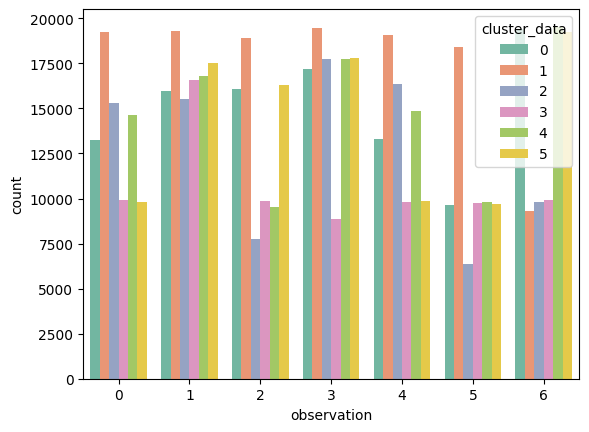

In [7]:
sns.countplot(x='observation', hue='cluster_data', data=df,palette=sns.color_palette("Set2"))
plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distirbution_plot.png", dpi=300, bbox_inches='tight')


### Running Data

In [8]:
import optuna
from xgboost import XGBClassifier

# Example dataset

# Define the objective function for Bayesian Optimization
def objective(trial,X_train, y_train, n_splits=3):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
        #'subsample': trial.suggest_uniform('subsample', 0.5, 0.7),
        #'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 0.7),
        #'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 0.7),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.1, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 100),
        'objective': 'multi:softprob',  # Multiclass classification
        'eval_metric': ['mlogloss'],
        "tree_method":'hist',
        "num_class": len(set(y_train)),
        "nthread":20
    }
    
    # Define the model
    skf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=42)
    f1_macros=[]
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(param, dtrain_fold, 
                          num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                          verbose_eval=False)
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
    score=np.mean(f1_macros)
    
    return score

In [9]:
def evaluate_model(X_train, y_train, X_test, y_test,cluster, best_params, n_splits=3):
    # Convert data to DMatrix for XGBoost
    class_counts = Counter(y_train)
    total_samples = len(y_train)
        # Step 3: Calculate class weights as inverse of class frequency
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = np.array([class_weights[label] for label in y_train])
        # Create DMatrix with sample weights
        
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True,weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)
    
    params = best_params
    params['objective']="multi:softprob"
    #params['tree_method']='approx'
    params['eval_metric']='mlogloss'
    params['num_class']=len(set(y_train))
    params['nthread']=20
    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracies = []
    f1_macros = []
    f1_micros = []
    aucs = []
    acc_kelas_generatifs = []
    acc_fase_padis = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        class_counts = Counter(y_train_fold)
        total_samples = len(y_train_fold)
        # Step 3: Calculate class weights as inverse of class frequency
        class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
        sample_weights = np.array([class_weights[label] for label in y_train_fold])
        # Create DMatrix with sample weights
        dtrain_fold = xgb.DMatrix(X_train_fold, label=y_train_fold, enable_categorical=True, weight=sample_weights)
        dval_fold = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
        
        evals = [(dtrain_fold, 'train'), (dval_fold, 'eval')]
        model = xgb.train(params, dtrain_fold, 
                          num_boost_round=10000, evals=evals,early_stopping_rounds=1000,verbose_eval=100)
        
        y_val_pred_prob = model.predict(dval_fold)
        y_val_pred = y_val_pred_prob.argmax(axis=1)
        
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))
        f1_macros.append(f1_score(y_val_fold, y_val_pred, average='macro'))
        f1_micros.append(f1_score(y_val_fold, y_val_pred, average='micro'))
        aucs.append(roc_auc_score(y_val_fold, y_val_pred_prob, multi_class='ovr'))
        acc_kelas_generatifs.append(akurasi_kelas_generatif(y_val_fold, y_val_pred))
        acc_fase_padis.append(akurasi_fase_padi(y_val_fold, y_val_pred))

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1_macro = sum(f1_macros) / len(f1_macros)
    avg_f1_micro = sum(f1_micros) / len(f1_micros)
    avg_auc = sum(aucs) / len(aucs)
    avg_acc_kelas_generatif = sum(acc_kelas_generatifs) / len(acc_kelas_generatifs)
    avg_acc_fase_padi = sum(acc_fase_padis) / len(acc_fase_padis)
    training_metrics = {
        "average_accuracy": avg_accuracy,
        "average_f1_macro": avg_f1_macro,
        "average_f1_micro": avg_f1_micro,
        "average_auc": avg_auc,
        "average_acc_kelas_generatif": avg_acc_kelas_generatif,
        "average_acc_fase_padi": avg_acc_fase_padi
    }

    
    # Final model evaluation on the test set
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    model = xgb.train(params, dtrain, 
                      num_boost_round=1000, evals=evals,early_stopping_rounds=50,
                      verbose_eval=50)
    y_test_pred_prob = model.predict(dtest)
    y_test_pred = y_test_pred_prob.argmax(axis=1)

    accuracy = accuracy_score(y_test, y_test_pred)
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_micro = f1_score(y_test, y_test_pred, average='micro')
    auc = roc_auc_score(y_test, y_test_pred_prob, multi_class='ovr')
    acc_kelas_generatif = akurasi_kelas_generatif(y_test, y_test_pred)
    acc_fase_padi = akurasi_fase_padi(y_test, y_test_pred)
    
    cm = confusion_matrix(y_test, y_test_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    validation_metrics = {
        "val_accuracy": accuracy,
        "val_f1_macro": f1_macro,
        "val_f1_micro": f1_micro,
        "val_auc": auc,
        "val_acc_kelas_generatif": acc_kelas_generatif,
        "val_acc_fase_padi": acc_fase_padi,
        "val_relative_acc": relative_acc
    }

    print("\nClassification Report on Test Set:")
    report = classification_report(y_test, y_test_pred)
    print(report)
    
    # Display Confusion Matrix
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_cm_cluster_{cluster}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, training_metrics, validation_metrics, report, cm

CLUSTER:  0


[I 2024-10-16 07:57:20,715] A new study created in memory with name: no-name-f041195a-594e-4291-acd4-e3d7144fb341


[2 4 1 3 0 6 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 07:58:05,824] Trial 0 finished with value: 0.8994703058901689 and parameters: {'max_depth': 6, 'learning_rate': 0.06423235110913215, 'reg_lambda': 2.399480361614388, 'min_child_weight': 76}. Best is trial 0 with value: 0.8994703058901689.


[I 2024-10-16 07:58:45,194] Trial 1 finished with value: 0.8981801800214972 and parameters: {'max_depth': 9, 'learning_rate': 0.06473937502641422, 'reg_lambda': 1.8921258049906018, 'min_child_weight': 86}. Best is trial 0 with value: 0.8994703058901689.


[I 2024-10-16 07:59:36,068] Trial 2 finished with value: 0.8991151963986663 and parameters: {'max_depth': 6, 'learning_rate': 0.06321564864411172, 'reg_lambda': 4.749390568866303, 'min_child_weight': 61}. Best is trial 0 with value: 0.8994703058901689.


[I 2024-10-16 08:00:21,702] Trial 3 finished with value: 0.8995540357818719 and parameters: {'max_depth': 10, 'learning_rate': 0.043571394364652405, 'reg_lambda': 1.5719928518153476, 'min_child_weight': 83}. Best is trial 3 with value: 0.8995540357818719.


[I 2024-10-16 08:01:33,531] Trial 4 finished with value: 0.8990856686653231 and parameters: {'max_depth': 8, 'learning_rate': 0.052183049377718754, 'reg_lambda': 0.970277714719843, 'min_child_weight': 83}. Best is trial 3 with value: 0.8995540357818719.


[I 2024-10-16 08:02:02,613] Trial 5 finished with value: 0.8983486814475059 and parameters: {'max_depth': 9, 'learning_rate': 0.09838248312789194, 'reg_lambda': 3.040671604275848, 'min_child_weight': 73}. Best is trial 3 with value: 0.8995540357818719.


[I 2024-10-16 08:02:43,010] Trial 6 finished with value: 0.899389550795723 and parameters: {'max_depth': 6, 'learning_rate': 0.07133357402761359, 'reg_lambda': 4.571942894376443, 'min_child_weight': 66}. Best is trial 3 with value: 0.8995540357818719.


[I 2024-10-16 08:03:16,989] Trial 7 finished with value: 0.9001176775377216 and parameters: {'max_depth': 7, 'learning_rate': 0.08652741672609919, 'reg_lambda': 2.1797819453979748, 'min_child_weight': 53}. Best is trial 7 with value: 0.9001176775377216.


[I 2024-10-16 08:04:07,279] Trial 8 finished with value: 0.8987237761483918 and parameters: {'max_depth': 7, 'learning_rate': 0.05763970930247083, 'reg_lambda': 2.4162784526827465, 'min_child_weight': 65}. Best is trial 7 with value: 0.9001176775377216.


[I 2024-10-16 08:04:38,084] Trial 9 finished with value: 0.8986053290787517 and parameters: {'max_depth': 10, 'learning_rate': 0.09706033944809989, 'reg_lambda': 2.8108349705722593, 'min_child_weight': 68}. Best is trial 7 with value: 0.9001176775377216.


[I 2024-10-16 08:06:18,767] Trial 10 finished with value: 0.8949160378467983 and parameters: {'max_depth': 7, 'learning_rate': 0.014242150667420295, 'reg_lambda': 0.12024375756611771, 'min_child_weight': 51}. Best is trial 7 with value: 0.9001176775377216.


[I 2024-10-16 08:07:48,082] Trial 11 finished with value: 0.8990443624497555 and parameters: {'max_depth': 10, 'learning_rate': 0.03509819483779539, 'reg_lambda': 1.3728000249210297, 'min_child_weight': 96}. Best is trial 7 with value: 0.9001176775377216.


[I 2024-10-16 08:09:01,222] Trial 12 finished with value: 0.8981240195887915 and parameters: {'max_depth': 8, 'learning_rate': 0.03604891896173671, 'reg_lambda': 3.695573886505917, 'min_child_weight': 53}. Best is trial 7 with value: 0.9001176775377216.


[I 2024-10-16 08:09:37,833] Trial 13 finished with value: 0.8999897241250338 and parameters: {'max_depth': 7, 'learning_rate': 0.08613724674156199, 'reg_lambda': 0.9852971624009917, 'min_child_weight': 100}. Best is trial 7 with value: 0.9001176775377216.


[I 2024-10-16 08:10:13,916] Trial 14 finished with value: 0.8992188798457846 and parameters: {'max_depth': 7, 'learning_rate': 0.08272524061809639, 'reg_lambda': 0.33403343417890174, 'min_child_weight': 100}. Best is trial 7 with value: 0.9001176775377216.


[I 2024-10-16 08:10:48,406] Trial 15 finished with value: 0.9004347905234488 and parameters: {'max_depth': 8, 'learning_rate': 0.08180150648794125, 'reg_lambda': 0.7808267275601752, 'min_child_weight': 92}. Best is trial 15 with value: 0.9004347905234488.


[I 2024-10-16 08:11:24,423] Trial 16 finished with value: 0.9004551965114262 and parameters: {'max_depth': 8, 'learning_rate': 0.08269804213198961, 'reg_lambda': 3.545435721102551, 'min_child_weight': 92}. Best is trial 16 with value: 0.9004551965114262.


[I 2024-10-16 08:11:55,481] Trial 17 finished with value: 0.8987948393583163 and parameters: {'max_depth': 8, 'learning_rate': 0.0776917962163529, 'reg_lambda': 3.6956191248981773, 'min_child_weight': 91}. Best is trial 16 with value: 0.9004551965114262.


[I 2024-10-16 08:12:24,876] Trial 18 finished with value: 0.899448717271324 and parameters: {'max_depth': 9, 'learning_rate': 0.07523279335276446, 'reg_lambda': 3.4532826209495187, 'min_child_weight': 91}. Best is trial 16 with value: 0.9004551965114262.


[I 2024-10-16 08:12:56,031] Trial 19 finished with value: 0.8985701365786133 and parameters: {'max_depth': 9, 'learning_rate': 0.09140614735288999, 'reg_lambda': 4.270899641081227, 'min_child_weight': 90}. Best is trial 16 with value: 0.9004551965114262.


Best Parameters: {'max_depth': 8, 'learning_rate': 0.08269804213198961, 'reg_lambda': 3.545435721102551, 'min_child_weight': 92}
Best Score: 0.9004551965114262
Start the modelling


[0]	train-mlogloss:1.75511	eval-mlogloss:1.76095


[100]	train-mlogloss:0.13120	eval-mlogloss:0.27243


[200]	train-mlogloss:0.06354	eval-mlogloss:0.24679


[300]	train-mlogloss:0.03934	eval-mlogloss:0.24426


[400]	train-mlogloss:0.02806	eval-mlogloss:0.24615


[500]	train-mlogloss:0.02186	eval-mlogloss:0.25040


[600]	train-mlogloss:0.01810	eval-mlogloss:0.25341


[700]	train-mlogloss:0.01558	eval-mlogloss:0.25615


[800]	train-mlogloss:0.01369	eval-mlogloss:0.25961


[900]	train-mlogloss:0.01227	eval-mlogloss:0.26251


[1000]	train-mlogloss:0.01113	eval-mlogloss:0.26513


[1100]	train-mlogloss:0.01024	eval-mlogloss:0.26762


[1200]	train-mlogloss:0.00952	eval-mlogloss:0.26965


[1286]	train-mlogloss:0.00901	eval-mlogloss:0.27121


[0]	train-mlogloss:1.75710	eval-mlogloss:1.75882


[100]	train-mlogloss:0.13704	eval-mlogloss:0.25885


[200]	train-mlogloss:0.06889	eval-mlogloss:0.23231


[300]	train-mlogloss:0.04300	eval-mlogloss:0.22814


[400]	train-mlogloss:0.03062	eval-mlogloss:0.22920


[500]	train-mlogloss:0.02356	eval-mlogloss:0.23177


[600]	train-mlogloss:0.01920	eval-mlogloss:0.23514


[700]	train-mlogloss:0.01627	eval-mlogloss:0.23837


[800]	train-mlogloss:0.01424	eval-mlogloss:0.24089


[900]	train-mlogloss:0.01273	eval-mlogloss:0.24354


[1000]	train-mlogloss:0.01156	eval-mlogloss:0.24584


[1100]	train-mlogloss:0.01061	eval-mlogloss:0.24799


[1200]	train-mlogloss:0.00988	eval-mlogloss:0.24999


[1299]	train-mlogloss:0.00927	eval-mlogloss:0.25184


[0]	train-mlogloss:1.75601	eval-mlogloss:1.75942


[100]	train-mlogloss:0.13035	eval-mlogloss:0.26525


[200]	train-mlogloss:0.06341	eval-mlogloss:0.24224


[300]	train-mlogloss:0.03964	eval-mlogloss:0.24039


[400]	train-mlogloss:0.02804	eval-mlogloss:0.24391


[500]	train-mlogloss:0.02188	eval-mlogloss:0.24809


[600]	train-mlogloss:0.01816	eval-mlogloss:0.25170


[700]	train-mlogloss:0.01556	eval-mlogloss:0.25550


[800]	train-mlogloss:0.01370	eval-mlogloss:0.25885


[900]	train-mlogloss:0.01226	eval-mlogloss:0.26186


[1000]	train-mlogloss:0.01114	eval-mlogloss:0.26448


[1100]	train-mlogloss:0.01028	eval-mlogloss:0.26724


[1200]	train-mlogloss:0.00957	eval-mlogloss:0.26956


[1262]	train-mlogloss:0.00920	eval-mlogloss:0.27088


[0]	train-mlogloss:1.75360	eval-mlogloss:1.75503


[50]	train-mlogloss:0.25101	eval-mlogloss:0.32010


[100]	train-mlogloss:0.14238	eval-mlogloss:0.24523


[150]	train-mlogloss:0.10191	eval-mlogloss:0.22587


[200]	train-mlogloss:0.07644	eval-mlogloss:0.21707


[250]	train-mlogloss:0.06033	eval-mlogloss:0.21294


[300]	train-mlogloss:0.04863	eval-mlogloss:0.21101


[350]	train-mlogloss:0.04029	eval-mlogloss:0.21031


[400]	train-mlogloss:0.03372	eval-mlogloss:0.21038


[424]	train-mlogloss:0.03137	eval-mlogloss:0.21043



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      9277
           1       0.93      0.96      0.94     11167
           2       0.95      0.96      0.96     11261
           3       0.95      0.95      0.95     12044
           4       0.94      0.97      0.96      9325
           5       0.80      0.58      0.67      6741
           6       0.91      0.97      0.94     13569

    accuracy                           0.93     73384
   macro avg       0.92      0.91      0.91     73384
weighted avg       0.93      0.93      0.92     73384



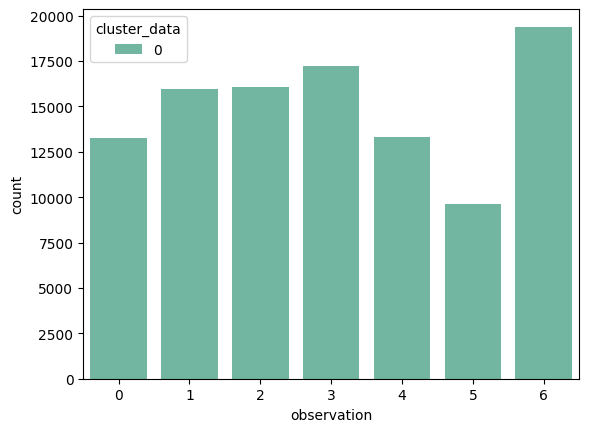

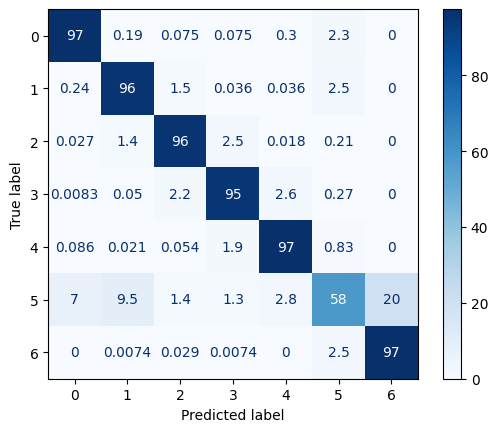

{'average_accuracy': 0.9201564437660975, 'average_f1_macro': np.float64(0.9015335905996142), 'average_f1_micro': np.float64(0.9201564437660975), 'average_auc': np.float64(0.9855602858519155), 'average_acc_kelas_generatif': 0.9453702327383123, 'average_acc_fase_padi': 0.9519444615892093}
{'val_accuracy': 0.9281587266979178, 'val_f1_macro': np.float64(0.9113807235740349), 'val_f1_micro': np.float64(0.9281587266979178), 'val_auc': np.float64(0.9879296936063172), 'val_acc_kelas_generatif': 0.9494354035204251, 'val_acc_fase_padi': 0.9580336552731922, 'val_relative_acc': np.float64(99.46397765546702)}
CLUSTER:  1


[I 2024-10-16 08:15:26,617] A new study created in memory with name: no-name-707a7411-7100-4767-9ac8-867c51797372


[1 6 2 5 4 3 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 08:16:06,599] Trial 0 finished with value: 0.8744833423907906 and parameters: {'max_depth': 7, 'learning_rate': 0.07601512126679062, 'reg_lambda': 1.5339074729706879, 'min_child_weight': 61}. Best is trial 0 with value: 0.8744833423907906.


[I 2024-10-16 08:16:52,962] Trial 1 finished with value: 0.8760665802411509 and parameters: {'max_depth': 10, 'learning_rate': 0.05252093348816326, 'reg_lambda': 0.7051418655014592, 'min_child_weight': 73}. Best is trial 1 with value: 0.8760665802411509.


[I 2024-10-16 08:17:52,451] Trial 2 finished with value: 0.8734923206300155 and parameters: {'max_depth': 7, 'learning_rate': 0.06830416363982066, 'reg_lambda': 4.797005891401888, 'min_child_weight': 90}. Best is trial 1 with value: 0.8760665802411509.


[I 2024-10-16 08:18:45,513] Trial 3 finished with value: 0.8748587051985813 and parameters: {'max_depth': 9, 'learning_rate': 0.06572620386308241, 'reg_lambda': 3.9276781199638227, 'min_child_weight': 72}. Best is trial 1 with value: 0.8760665802411509.


[I 2024-10-16 08:19:35,440] Trial 4 finished with value: 0.8734305183270918 and parameters: {'max_depth': 6, 'learning_rate': 0.09061323181218678, 'reg_lambda': 1.291826204577716, 'min_child_weight': 92}. Best is trial 1 with value: 0.8760665802411509.


[I 2024-10-16 08:20:29,464] Trial 5 finished with value: 0.8747104088692222 and parameters: {'max_depth': 8, 'learning_rate': 0.0737287183093058, 'reg_lambda': 1.4797691051238713, 'min_child_weight': 100}. Best is trial 1 with value: 0.8760665802411509.


[I 2024-10-16 08:21:07,808] Trial 6 finished with value: 0.8773041647730803 and parameters: {'max_depth': 10, 'learning_rate': 0.08461132597629227, 'reg_lambda': 0.3013569526638342, 'min_child_weight': 99}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:22:02,408] Trial 7 finished with value: 0.8739796734741598 and parameters: {'max_depth': 7, 'learning_rate': 0.06817681160734884, 'reg_lambda': 4.622885895924284, 'min_child_weight': 100}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:23:27,112] Trial 8 finished with value: 0.8728640786173193 and parameters: {'max_depth': 6, 'learning_rate': 0.05124191131297511, 'reg_lambda': 2.7966232512072384, 'min_child_weight': 98}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:25:18,141] Trial 9 finished with value: 0.8747501801848926 and parameters: {'max_depth': 7, 'learning_rate': 0.029491579359680886, 'reg_lambda': 4.293298433293468, 'min_child_weight': 50}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:26:27,372] Trial 10 finished with value: 0.8768006108107412 and parameters: {'max_depth': 10, 'learning_rate': 0.09992602743678758, 'reg_lambda': 0.19376130900084387, 'min_child_weight': 85}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:26:58,626] Trial 11 finished with value: 0.8764873930079982 and parameters: {'max_depth': 10, 'learning_rate': 0.09985797092107494, 'reg_lambda': 0.42430840300791084, 'min_child_weight': 83}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:27:27,025] Trial 12 finished with value: 0.876224099109352 and parameters: {'max_depth': 9, 'learning_rate': 0.08932268527299106, 'reg_lambda': 0.12204208202576866, 'min_child_weight': 86}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:28:03,326] Trial 13 finished with value: 0.8764161560997407 and parameters: {'max_depth': 9, 'learning_rate': 0.09862613111295851, 'reg_lambda': 2.432790052538821, 'min_child_weight': 80}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:29:37,922] Trial 14 finished with value: 0.8758674724712199 and parameters: {'max_depth': 10, 'learning_rate': 0.031683998826883844, 'reg_lambda': 2.3749868043087345, 'min_child_weight': 92}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:30:24,275] Trial 15 finished with value: 0.8756582257416784 and parameters: {'max_depth': 9, 'learning_rate': 0.081742216015722, 'reg_lambda': 0.8929344000747304, 'min_child_weight': 78}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:31:07,687] Trial 16 finished with value: 0.8765936935389158 and parameters: {'max_depth': 10, 'learning_rate': 0.08754647151162989, 'reg_lambda': 3.1895973696346407, 'min_child_weight': 68}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:33:30,275] Trial 17 finished with value: 0.8689708740771449 and parameters: {'max_depth': 8, 'learning_rate': 0.013167776232855394, 'reg_lambda': 1.8677375222454797, 'min_child_weight': 87}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:34:03,246] Trial 18 finished with value: 0.8767787122282344 and parameters: {'max_depth': 10, 'learning_rate': 0.0995344319197396, 'reg_lambda': 0.10552537679827201, 'min_child_weight': 93}. Best is trial 6 with value: 0.8773041647730803.


[I 2024-10-16 08:35:07,547] Trial 19 finished with value: 0.8764690082026689 and parameters: {'max_depth': 9, 'learning_rate': 0.04461017153499405, 'reg_lambda': 0.9502906204465693, 'min_child_weight': 64}. Best is trial 6 with value: 0.8773041647730803.


Best Parameters: {'max_depth': 10, 'learning_rate': 0.08461132597629227, 'reg_lambda': 0.3013569526638342, 'min_child_weight': 99}
Best Score: 0.8773041647730803
Start the modelling


[0]	train-mlogloss:1.75688	eval-mlogloss:1.76287


[100]	train-mlogloss:0.13973	eval-mlogloss:0.33010


[200]	train-mlogloss:0.06473	eval-mlogloss:0.30530


[300]	train-mlogloss:0.03878	eval-mlogloss:0.30396


[400]	train-mlogloss:0.02778	eval-mlogloss:0.30737


[500]	train-mlogloss:0.02167	eval-mlogloss:0.31143


[600]	train-mlogloss:0.01788	eval-mlogloss:0.31560


[700]	train-mlogloss:0.01544	eval-mlogloss:0.31984


[800]	train-mlogloss:0.01368	eval-mlogloss:0.32329


[900]	train-mlogloss:0.01238	eval-mlogloss:0.32642


[1000]	train-mlogloss:0.01136	eval-mlogloss:0.32886


[1100]	train-mlogloss:0.01055	eval-mlogloss:0.33129


[1200]	train-mlogloss:0.00990	eval-mlogloss:0.33317


[1269]	train-mlogloss:0.00951	eval-mlogloss:0.33436


[0]	train-mlogloss:1.75571	eval-mlogloss:1.76258


[100]	train-mlogloss:0.13601	eval-mlogloss:0.33321


[200]	train-mlogloss:0.06286	eval-mlogloss:0.31050


[300]	train-mlogloss:0.03820	eval-mlogloss:0.30948


[400]	train-mlogloss:0.02713	eval-mlogloss:0.31324


[500]	train-mlogloss:0.02121	eval-mlogloss:0.31740


[600]	train-mlogloss:0.01759	eval-mlogloss:0.32144


[700]	train-mlogloss:0.01520	eval-mlogloss:0.32558


[800]	train-mlogloss:0.01350	eval-mlogloss:0.32905


[900]	train-mlogloss:0.01222	eval-mlogloss:0.33203


[1000]	train-mlogloss:0.01122	eval-mlogloss:0.33426


[1100]	train-mlogloss:0.01044	eval-mlogloss:0.33644


[1200]	train-mlogloss:0.00980	eval-mlogloss:0.33886


[1254]	train-mlogloss:0.00950	eval-mlogloss:0.33988


[0]	train-mlogloss:1.75494	eval-mlogloss:1.76300


[100]	train-mlogloss:0.12877	eval-mlogloss:0.34065


[200]	train-mlogloss:0.05937	eval-mlogloss:0.31991


[300]	train-mlogloss:0.03628	eval-mlogloss:0.32024


[400]	train-mlogloss:0.02617	eval-mlogloss:0.32536


[500]	train-mlogloss:0.02066	eval-mlogloss:0.33040


[600]	train-mlogloss:0.01723	eval-mlogloss:0.33423


[700]	train-mlogloss:0.01490	eval-mlogloss:0.33824


[800]	train-mlogloss:0.01329	eval-mlogloss:0.34169


[900]	train-mlogloss:0.01205	eval-mlogloss:0.34468


[1000]	train-mlogloss:0.01110	eval-mlogloss:0.34733


[1100]	train-mlogloss:0.01034	eval-mlogloss:0.34992


[1200]	train-mlogloss:0.00970	eval-mlogloss:0.35222


[1255]	train-mlogloss:0.00940	eval-mlogloss:0.35328


[0]	train-mlogloss:1.75190	eval-mlogloss:1.75862


[50]	train-mlogloss:0.24277	eval-mlogloss:0.38704


[100]	train-mlogloss:0.14645	eval-mlogloss:0.32668


[150]	train-mlogloss:0.09952	eval-mlogloss:0.30784


[200]	train-mlogloss:0.07095	eval-mlogloss:0.29969


[250]	train-mlogloss:0.05338	eval-mlogloss:0.29684


[300]	train-mlogloss:0.04224	eval-mlogloss:0.29666


[324]	train-mlogloss:0.03839	eval-mlogloss:0.29700



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     13464
           1       0.91      0.91      0.91     13514
           2       0.89      0.92      0.91     13253
           3       0.91      0.91      0.91     13634
           4       0.91      0.93      0.92     13365
           5       0.90      0.93      0.91     12891
           6       0.78      0.63      0.70      6532

    accuracy                           0.90     86653
   macro avg       0.89      0.88      0.88     86653
weighted avg       0.89      0.90      0.90     86653



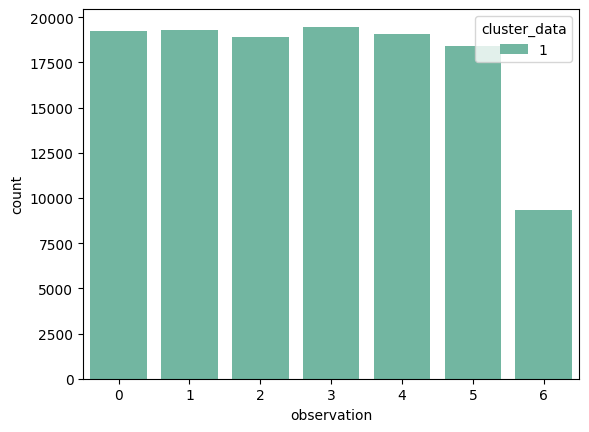

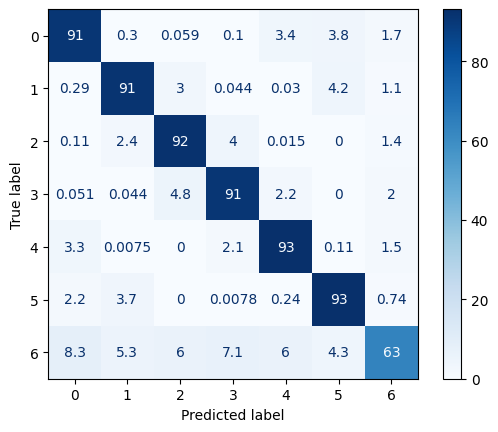

{'average_accuracy': 0.8958720413603684, 'average_f1_macro': np.float64(0.8794122318376837), 'average_f1_micro': np.float64(0.8958720413603684), 'average_auc': np.float64(0.9842601246064935), 'average_acc_kelas_generatif': 0.9135725226370129, 'average_acc_fase_padi': 0.9211038412346427}
{'val_accuracy': 0.8966798610550125, 'val_f1_macro': np.float64(0.8807881655297928), 'val_f1_micro': np.float64(0.8966798610550125), 'val_auc': np.float64(0.9857884085417314), 'val_acc_kelas_generatif': 0.9091242482030218, 'val_acc_fase_padi': 0.9182568909719897, 'val_relative_acc': np.float64(99.96921798285442)}
CLUSTER:  2


[I 2024-10-16 08:38:08,381] A new study created in memory with name: no-name-a8e06753-1fb0-4924-8219-d00aec1ac2fc


[6 2 1 0 4 3 5]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 08:38:37,276] Trial 0 finished with value: 0.9192297498828185 and parameters: {'max_depth': 6, 'learning_rate': 0.09652007136372698, 'reg_lambda': 3.6151251519209286, 'min_child_weight': 53}. Best is trial 0 with value: 0.9192297498828185.


[I 2024-10-16 08:39:22,532] Trial 1 finished with value: 0.9188984014548741 and parameters: {'max_depth': 8, 'learning_rate': 0.05621786140786244, 'reg_lambda': 1.7465039945557037, 'min_child_weight': 96}. Best is trial 0 with value: 0.9192297498828185.


[I 2024-10-16 08:39:49,439] Trial 2 finished with value: 0.9185252567103136 and parameters: {'max_depth': 7, 'learning_rate': 0.07978261689611586, 'reg_lambda': 1.4769248710784744, 'min_child_weight': 90}. Best is trial 0 with value: 0.9192297498828185.


[I 2024-10-16 08:40:19,500] Trial 3 finished with value: 0.920193742266763 and parameters: {'max_depth': 9, 'learning_rate': 0.08216594107105876, 'reg_lambda': 3.8722476111743567, 'min_child_weight': 62}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:41:02,609] Trial 4 finished with value: 0.9192213766269979 and parameters: {'max_depth': 10, 'learning_rate': 0.06204271861656283, 'reg_lambda': 2.55655566795009, 'min_child_weight': 64}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:41:53,880] Trial 5 finished with value: 0.9196586635030078 and parameters: {'max_depth': 7, 'learning_rate': 0.05866181343296043, 'reg_lambda': 0.6319887823925507, 'min_child_weight': 65}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:44:03,388] Trial 6 finished with value: 0.9175417292166353 and parameters: {'max_depth': 10, 'learning_rate': 0.016720313231091972, 'reg_lambda': 4.357202537731213, 'min_child_weight': 98}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:45:39,524] Trial 7 finished with value: 0.9154524973310085 and parameters: {'max_depth': 6, 'learning_rate': 0.019365741646706153, 'reg_lambda': 1.296463583426492, 'min_child_weight': 82}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:46:42,258] Trial 8 finished with value: 0.9185698854592372 and parameters: {'max_depth': 6, 'learning_rate': 0.0334183822405442, 'reg_lambda': 1.8808505654850818, 'min_child_weight': 64}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:47:12,290] Trial 9 finished with value: 0.91896423908707 and parameters: {'max_depth': 6, 'learning_rate': 0.09606727642923084, 'reg_lambda': 3.8789944969624837, 'min_child_weight': 88}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:47:48,084] Trial 10 finished with value: 0.9192495531596409 and parameters: {'max_depth': 9, 'learning_rate': 0.07466181325075039, 'reg_lambda': 4.997481163420689, 'min_child_weight': 53}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:48:54,411] Trial 11 finished with value: 0.9180119675352169 and parameters: {'max_depth': 8, 'learning_rate': 0.03741173502332487, 'reg_lambda': 2.7538220852656177, 'min_child_weight': 68}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:49:30,910] Trial 12 finished with value: 0.9182352858003152 and parameters: {'max_depth': 8, 'learning_rate': 0.07693673206619125, 'reg_lambda': 0.2740975502473342, 'min_child_weight': 74}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:50:34,056] Trial 13 finished with value: 0.9185459847144442 and parameters: {'max_depth': 9, 'learning_rate': 0.040993909981169786, 'reg_lambda': 0.3055759685631396, 'min_child_weight': 58}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:51:12,737] Trial 14 finished with value: 0.9198118065852489 and parameters: {'max_depth': 7, 'learning_rate': 0.06621702414298844, 'reg_lambda': 3.237164797974856, 'min_child_weight': 74}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:51:59,163] Trial 15 finished with value: 0.9192957291887165 and parameters: {'max_depth': 9, 'learning_rate': 0.08478099446907367, 'reg_lambda': 3.3273051047204527, 'min_child_weight': 76}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:52:42,099] Trial 16 finished with value: 0.9200151811182021 and parameters: {'max_depth': 7, 'learning_rate': 0.06882965331619405, 'reg_lambda': 3.031814973821959, 'min_child_weight': 74}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:53:22,074] Trial 17 finished with value: 0.9184556699018288 and parameters: {'max_depth': 8, 'learning_rate': 0.08863327966081291, 'reg_lambda': 4.449586710824498, 'min_child_weight': 80}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:53:58,841] Trial 18 finished with value: 0.9194231780813822 and parameters: {'max_depth': 9, 'learning_rate': 0.07171908894479792, 'reg_lambda': 2.9356783357839507, 'min_child_weight': 70}. Best is trial 3 with value: 0.920193742266763.


[I 2024-10-16 08:54:52,792] Trial 19 finished with value: 0.920348326779199 and parameters: {'max_depth': 7, 'learning_rate': 0.046823677592178266, 'reg_lambda': 2.2657862256305954, 'min_child_weight': 58}. Best is trial 19 with value: 0.920348326779199.


Best Parameters: {'max_depth': 7, 'learning_rate': 0.046823677592178266, 'reg_lambda': 2.2657862256305954, 'min_child_weight': 58}
Best Score: 0.920348326779199
Start the modelling


[0]	train-mlogloss:1.82654	eval-mlogloss:1.83190


[100]	train-mlogloss:0.18007	eval-mlogloss:0.30828


[200]	train-mlogloss:0.08990	eval-mlogloss:0.24943


[300]	train-mlogloss:0.05364	eval-mlogloss:0.23392


[400]	train-mlogloss:0.03619	eval-mlogloss:0.22869


[500]	train-mlogloss:0.02657	eval-mlogloss:0.22744


[600]	train-mlogloss:0.02079	eval-mlogloss:0.22749


[700]	train-mlogloss:0.01703	eval-mlogloss:0.22861


[800]	train-mlogloss:0.01442	eval-mlogloss:0.22994


[900]	train-mlogloss:0.01261	eval-mlogloss:0.23116


[1000]	train-mlogloss:0.01114	eval-mlogloss:0.23283


[1100]	train-mlogloss:0.01002	eval-mlogloss:0.23464


[1200]	train-mlogloss:0.00913	eval-mlogloss:0.23604


[1300]	train-mlogloss:0.00842	eval-mlogloss:0.23755


[1400]	train-mlogloss:0.00781	eval-mlogloss:0.23871


[1500]	train-mlogloss:0.00732	eval-mlogloss:0.24008


[1560]	train-mlogloss:0.00706	eval-mlogloss:0.24089


[0]	train-mlogloss:1.82716	eval-mlogloss:1.83175


[100]	train-mlogloss:0.18283	eval-mlogloss:0.31039


[200]	train-mlogloss:0.09104	eval-mlogloss:0.24737


[300]	train-mlogloss:0.05631	eval-mlogloss:0.23073


[400]	train-mlogloss:0.03708	eval-mlogloss:0.22478


[500]	train-mlogloss:0.02709	eval-mlogloss:0.22350


[600]	train-mlogloss:0.02089	eval-mlogloss:0.22402


[700]	train-mlogloss:0.01698	eval-mlogloss:0.22536


[800]	train-mlogloss:0.01439	eval-mlogloss:0.22714


[900]	train-mlogloss:0.01252	eval-mlogloss:0.22914


[1000]	train-mlogloss:0.01112	eval-mlogloss:0.23085


[1100]	train-mlogloss:0.01000	eval-mlogloss:0.23247


[1200]	train-mlogloss:0.00910	eval-mlogloss:0.23419


[1300]	train-mlogloss:0.00840	eval-mlogloss:0.23582


[1400]	train-mlogloss:0.00782	eval-mlogloss:0.23732


[1500]	train-mlogloss:0.00735	eval-mlogloss:0.23881


[1537]	train-mlogloss:0.00719	eval-mlogloss:0.23932


[0]	train-mlogloss:1.82699	eval-mlogloss:1.83116


[100]	train-mlogloss:0.18398	eval-mlogloss:0.30223


[200]	train-mlogloss:0.09271	eval-mlogloss:0.24504


[300]	train-mlogloss:0.05747	eval-mlogloss:0.23119


[400]	train-mlogloss:0.03804	eval-mlogloss:0.22609


[500]	train-mlogloss:0.02782	eval-mlogloss:0.22556


[600]	train-mlogloss:0.02150	eval-mlogloss:0.22598


[700]	train-mlogloss:0.01742	eval-mlogloss:0.22752


[800]	train-mlogloss:0.01459	eval-mlogloss:0.22926


[900]	train-mlogloss:0.01265	eval-mlogloss:0.23101


[1000]	train-mlogloss:0.01118	eval-mlogloss:0.23248


[1100]	train-mlogloss:0.01003	eval-mlogloss:0.23408


[1200]	train-mlogloss:0.00915	eval-mlogloss:0.23550


[1300]	train-mlogloss:0.00844	eval-mlogloss:0.23715


[1400]	train-mlogloss:0.00783	eval-mlogloss:0.23846


[1500]	train-mlogloss:0.00733	eval-mlogloss:0.23987


[1526]	train-mlogloss:0.00722	eval-mlogloss:0.24031


[0]	train-mlogloss:1.82653	eval-mlogloss:1.83013


[50]	train-mlogloss:0.38126	eval-mlogloss:0.45982


[100]	train-mlogloss:0.19311	eval-mlogloss:0.30257


[150]	train-mlogloss:0.13493	eval-mlogloss:0.26255


[200]	train-mlogloss:0.10217	eval-mlogloss:0.24445


[250]	train-mlogloss:0.08115	eval-mlogloss:0.23449


[300]	train-mlogloss:0.06520	eval-mlogloss:0.22817


[350]	train-mlogloss:0.05380	eval-mlogloss:0.22436


[400]	train-mlogloss:0.04554	eval-mlogloss:0.22215


[450]	train-mlogloss:0.03901	eval-mlogloss:0.22077


[500]	train-mlogloss:0.03368	eval-mlogloss:0.22011


[550]	train-mlogloss:0.02932	eval-mlogloss:0.21979


[600]	train-mlogloss:0.02579	eval-mlogloss:0.21983


[622]	train-mlogloss:0.02445	eval-mlogloss:0.21998



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10697
           1       0.96      0.97      0.96     10852
           2       0.91      0.88      0.89      5419
           3       0.95      0.95      0.95     12403
           4       0.96      0.98      0.97     11447
           5       0.93      0.97      0.95      4462
           6       0.84      0.76      0.80      6878

    accuracy                           0.93     62158
   macro avg       0.92      0.92      0.92     62158
weighted avg       0.93      0.93      0.93     62158



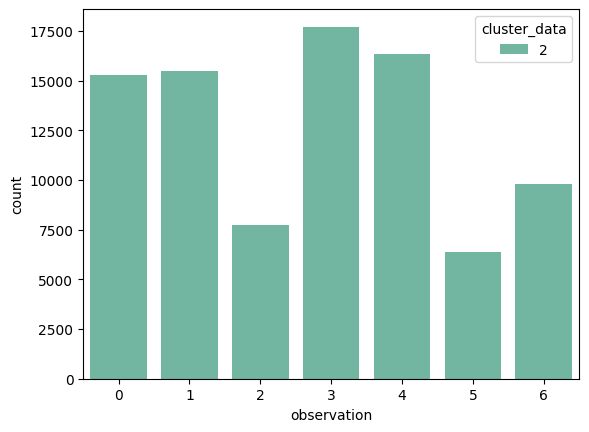

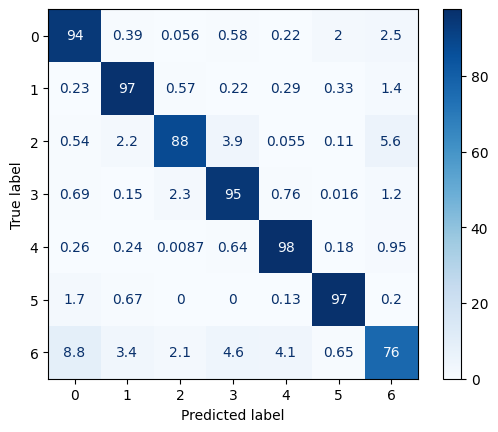

{'average_accuracy': 0.9319043998948832, 'average_f1_macro': np.float64(0.9220954726250093), 'average_f1_micro': np.float64(0.9319043998948832), 'average_auc': np.float64(0.9911527905573045), 'average_acc_kelas_generatif': 0.9525959367945824, 'average_acc_fase_padi': 0.9532447368391068}
{'val_accuracy': 0.9314488883168699, 'val_f1_macro': np.float64(0.9220252271314325), 'val_f1_micro': np.float64(0.9314488883168699), 'val_auc': np.float64(0.9911111363122126), 'val_acc_kelas_generatif': 0.9486414577118439, 'val_acc_fase_padi': 0.9525684803469505, 'val_relative_acc': np.float64(99.73856209150327)}
CLUSTER:  3


[I 2024-10-16 08:57:36,730] A new study created in memory with name: no-name-15f513d5-e9b6-46ef-8a51-96f97538ecb8


[6 4 5 2 1 3 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 08:58:04,653] Trial 0 finished with value: 0.5770863323766137 and parameters: {'max_depth': 6, 'learning_rate': 0.06638548518879962, 'reg_lambda': 3.4863975703366115, 'min_child_weight': 96}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 08:58:45,230] Trial 1 finished with value: 0.5744974566102625 and parameters: {'max_depth': 8, 'learning_rate': 0.04856957477421152, 'reg_lambda': 3.208547101437683, 'min_child_weight': 92}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 08:59:52,880] Trial 2 finished with value: 0.576511069356664 and parameters: {'max_depth': 8, 'learning_rate': 0.026910066327897643, 'reg_lambda': 2.544651804646782, 'min_child_weight': 75}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:00:31,758] Trial 3 finished with value: 0.5763627003654389 and parameters: {'max_depth': 7, 'learning_rate': 0.049958810854913105, 'reg_lambda': 4.272278315485476, 'min_child_weight': 91}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:01:09,612] Trial 4 finished with value: 0.575140011664118 and parameters: {'max_depth': 10, 'learning_rate': 0.05895194351290883, 'reg_lambda': 2.6754232760052568, 'min_child_weight': 73}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:01:40,756] Trial 5 finished with value: 0.5743385481257379 and parameters: {'max_depth': 8, 'learning_rate': 0.07373422065163986, 'reg_lambda': 4.193771632278576, 'min_child_weight': 86}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:02:28,794] Trial 6 finished with value: 0.5749087357161987 and parameters: {'max_depth': 10, 'learning_rate': 0.04404855435605013, 'reg_lambda': 1.1329864715281817, 'min_child_weight': 52}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:04:17,068] Trial 7 finished with value: 0.5753615492123688 and parameters: {'max_depth': 8, 'learning_rate': 0.013991639162061066, 'reg_lambda': 1.07525286482245, 'min_child_weight': 83}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:04:34,020] Trial 8 finished with value: 0.5709840517875316 and parameters: {'max_depth': 10, 'learning_rate': 0.09762725998259295, 'reg_lambda': 3.1199925022115242, 'min_child_weight': 59}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:05:01,334] Trial 9 finished with value: 0.5736997497519484 and parameters: {'max_depth': 9, 'learning_rate': 0.06239749564658047, 'reg_lambda': 4.266913554387182, 'min_child_weight': 59}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:05:23,662] Trial 10 finished with value: 0.576675759688379 and parameters: {'max_depth': 6, 'learning_rate': 0.0874084892633974, 'reg_lambda': 4.982715591372157, 'min_child_weight': 99}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:05:42,743] Trial 11 finished with value: 0.5765361615388831 and parameters: {'max_depth': 6, 'learning_rate': 0.0877878647704096, 'reg_lambda': 4.928661238232852, 'min_child_weight': 99}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:06:04,078] Trial 12 finished with value: 0.5739687007428069 and parameters: {'max_depth': 6, 'learning_rate': 0.07784286624162255, 'reg_lambda': 4.89017517399482, 'min_child_weight': 99}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:06:28,726] Trial 13 finished with value: 0.5735035095111276 and parameters: {'max_depth': 6, 'learning_rate': 0.0760655904504651, 'reg_lambda': 1.8077262400617193, 'min_child_weight': 99}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:06:50,281] Trial 14 finished with value: 0.5740582851442267 and parameters: {'max_depth': 7, 'learning_rate': 0.09947232939178802, 'reg_lambda': 3.6029487152056614, 'min_child_weight': 79}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:07:15,371] Trial 15 finished with value: 0.5751452474931656 and parameters: {'max_depth': 7, 'learning_rate': 0.08486417673081907, 'reg_lambda': 0.2944934860333208, 'min_child_weight': 91}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:07:47,122] Trial 16 finished with value: 0.5761869132493308 and parameters: {'max_depth': 6, 'learning_rate': 0.06677500627210385, 'reg_lambda': 3.8060560182570877, 'min_child_weight': 71}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:08:36,527] Trial 17 finished with value: 0.5723799242628754 and parameters: {'max_depth': 7, 'learning_rate': 0.036067058847999246, 'reg_lambda': 2.290371920486647, 'min_child_weight': 93}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:08:58,662] Trial 18 finished with value: 0.5739996833210594 and parameters: {'max_depth': 6, 'learning_rate': 0.09035879839755859, 'reg_lambda': 4.963288349969521, 'min_child_weight': 85}. Best is trial 0 with value: 0.5770863323766137.


[I 2024-10-16 09:09:28,272] Trial 19 finished with value: 0.5756623806712358 and parameters: {'max_depth': 7, 'learning_rate': 0.06785138633831539, 'reg_lambda': 3.520429301673258, 'min_child_weight': 66}. Best is trial 0 with value: 0.5770863323766137.


Best Parameters: {'max_depth': 6, 'learning_rate': 0.06638548518879962, 'reg_lambda': 3.4863975703366115, 'min_child_weight': 96}
Best Score: 0.5770863323766137
Start the modelling


[0]	train-mlogloss:1.87255	eval-mlogloss:1.87498


[100]	train-mlogloss:0.85122	eval-mlogloss:1.05461


[200]	train-mlogloss:0.69607	eval-mlogloss:1.02533


[300]	train-mlogloss:0.58453	eval-mlogloss:1.02168


[400]	train-mlogloss:0.49109	eval-mlogloss:1.02340


[500]	train-mlogloss:0.41119	eval-mlogloss:1.02793


[600]	train-mlogloss:0.34736	eval-mlogloss:1.03466


[700]	train-mlogloss:0.29829	eval-mlogloss:1.04259


[800]	train-mlogloss:0.25595	eval-mlogloss:1.04964


[900]	train-mlogloss:0.22292	eval-mlogloss:1.05751


[1000]	train-mlogloss:0.19457	eval-mlogloss:1.06559


[1100]	train-mlogloss:0.17074	eval-mlogloss:1.07500


[1200]	train-mlogloss:0.15139	eval-mlogloss:1.08395


[1283]	train-mlogloss:0.13753	eval-mlogloss:1.09181


[0]	train-mlogloss:1.87356	eval-mlogloss:1.87368


[100]	train-mlogloss:0.85324	eval-mlogloss:1.04724


[200]	train-mlogloss:0.69943	eval-mlogloss:1.01854


[300]	train-mlogloss:0.58528	eval-mlogloss:1.01327


[400]	train-mlogloss:0.49262	eval-mlogloss:1.01529


[500]	train-mlogloss:0.41609	eval-mlogloss:1.01964


[600]	train-mlogloss:0.35124	eval-mlogloss:1.02608


[700]	train-mlogloss:0.29778	eval-mlogloss:1.03418


[800]	train-mlogloss:0.25705	eval-mlogloss:1.04150


[900]	train-mlogloss:0.22212	eval-mlogloss:1.05067


[1000]	train-mlogloss:0.19323	eval-mlogloss:1.05965


[1100]	train-mlogloss:0.16926	eval-mlogloss:1.06819


[1200]	train-mlogloss:0.14868	eval-mlogloss:1.07694


[1289]	train-mlogloss:0.13391	eval-mlogloss:1.08494


[0]	train-mlogloss:1.87284	eval-mlogloss:1.87500


[100]	train-mlogloss:0.85777	eval-mlogloss:1.04896


[200]	train-mlogloss:0.70070	eval-mlogloss:1.02118


[300]	train-mlogloss:0.58530	eval-mlogloss:1.01456


[400]	train-mlogloss:0.49058	eval-mlogloss:1.01564


[500]	train-mlogloss:0.41407	eval-mlogloss:1.02072


[600]	train-mlogloss:0.35009	eval-mlogloss:1.02677


[700]	train-mlogloss:0.29914	eval-mlogloss:1.03398


[800]	train-mlogloss:0.25725	eval-mlogloss:1.04249


[900]	train-mlogloss:0.22486	eval-mlogloss:1.05121


[1000]	train-mlogloss:0.19618	eval-mlogloss:1.06025


[1100]	train-mlogloss:0.17280	eval-mlogloss:1.06874


[1200]	train-mlogloss:0.15252	eval-mlogloss:1.07758


[1300]	train-mlogloss:0.13439	eval-mlogloss:1.08627


[1349]	train-mlogloss:0.12753	eval-mlogloss:1.09044


[0]	train-mlogloss:1.87311	eval-mlogloss:1.87410


[50]	train-mlogloss:1.02976	eval-mlogloss:1.11482


[100]	train-mlogloss:0.89037	eval-mlogloss:1.04010


[150]	train-mlogloss:0.81383	eval-mlogloss:1.01872


[200]	train-mlogloss:0.74884	eval-mlogloss:1.00788


[250]	train-mlogloss:0.69572	eval-mlogloss:1.00226


[300]	train-mlogloss:0.64612	eval-mlogloss:0.99902


[350]	train-mlogloss:0.60275	eval-mlogloss:0.99722


[400]	train-mlogloss:0.55835	eval-mlogloss:0.99652


[450]	train-mlogloss:0.51788	eval-mlogloss:0.99643


[485]	train-mlogloss:0.49542	eval-mlogloss:0.99721



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.46      0.46      0.46      6935
           1       0.86      0.91      0.89     11608
           2       0.52      0.47      0.49      6905
           3       0.92      0.97      0.95      6192
           4       0.55      0.52      0.53      6855
           5       0.45      0.42      0.44      6817
           6       0.33      0.34      0.33      6925

    accuracy                           0.61     52237
   macro avg       0.58      0.59      0.58     52237
weighted avg       0.60      0.61      0.61     52237



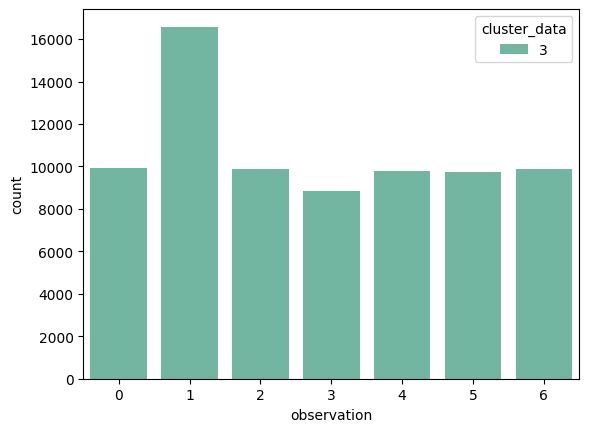

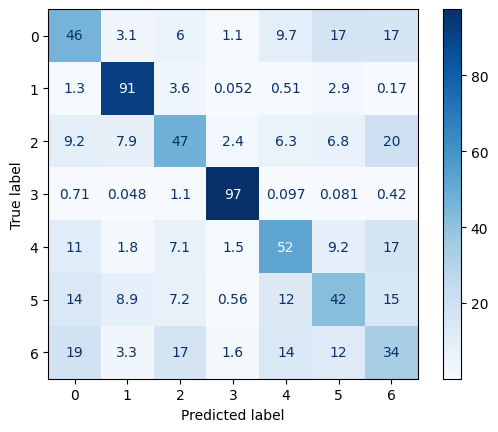

{'average_accuracy': 0.6020280532475654, 'average_f1_macro': np.float64(0.5729476505860949), 'average_f1_micro': np.float64(0.6020280532475654), 'average_auc': np.float64(0.8761278806350132), 'average_acc_kelas_generatif': 0.9747560736593638, 'average_acc_fase_padi': 0.7450837586714899}
{'val_accuracy': 0.6109079771043513, 'val_f1_macro': np.float64(0.5844990586007006), 'val_f1_micro': np.float64(0.6109079771043513), 'val_auc': np.float64(0.8841581879825409), 'val_acc_kelas_generatif': 0.974967700258398, 'val_acc_fase_padi': 0.7445817490494296, 'val_relative_acc': np.float64(93.4067980754307)}
CLUSTER:  4


[I 2024-10-16 09:11:28,962] A new study created in memory with name: no-name-ae974137-60e4-48e5-88cf-aac2c22503ac


[2 6 3 1 4 5 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 09:11:58,058] Trial 0 finished with value: 0.840371589915247 and parameters: {'max_depth': 9, 'learning_rate': 0.08973609153145921, 'reg_lambda': 3.550435127458888, 'min_child_weight': 90}. Best is trial 0 with value: 0.840371589915247.


[I 2024-10-16 09:12:45,690] Trial 1 finished with value: 0.8402821341041782 and parameters: {'max_depth': 8, 'learning_rate': 0.053187871833425986, 'reg_lambda': 1.7046759807814678, 'min_child_weight': 82}. Best is trial 0 with value: 0.840371589915247.


[I 2024-10-16 09:14:36,285] Trial 2 finished with value: 0.8398229339719173 and parameters: {'max_depth': 9, 'learning_rate': 0.016995811354969543, 'reg_lambda': 1.2648751526659479, 'min_child_weight': 91}. Best is trial 0 with value: 0.840371589915247.


[I 2024-10-16 09:15:32,930] Trial 3 finished with value: 0.8392314288565078 and parameters: {'max_depth': 8, 'learning_rate': 0.07514414311197413, 'reg_lambda': 0.5602801077360956, 'min_child_weight': 94}. Best is trial 0 with value: 0.840371589915247.


[I 2024-10-16 09:16:19,620] Trial 4 finished with value: 0.840357138176663 and parameters: {'max_depth': 6, 'learning_rate': 0.06196950367851938, 'reg_lambda': 0.6490951835616231, 'min_child_weight': 97}. Best is trial 0 with value: 0.840371589915247.


[I 2024-10-16 09:17:04,794] Trial 5 finished with value: 0.839744230044165 and parameters: {'max_depth': 10, 'learning_rate': 0.05729563629537696, 'reg_lambda': 1.4070654002521539, 'min_child_weight': 86}. Best is trial 0 with value: 0.840371589915247.


[I 2024-10-16 09:17:46,786] Trial 6 finished with value: 0.8396181680329096 and parameters: {'max_depth': 10, 'learning_rate': 0.06246715794172069, 'reg_lambda': 0.5049660669282126, 'min_child_weight': 88}. Best is trial 0 with value: 0.840371589915247.


[I 2024-10-16 09:18:38,807] Trial 7 finished with value: 0.8407945403040523 and parameters: {'max_depth': 8, 'learning_rate': 0.0542812214551496, 'reg_lambda': 4.85163579789338, 'min_child_weight': 65}. Best is trial 7 with value: 0.8407945403040523.


[I 2024-10-16 09:20:11,730] Trial 8 finished with value: 0.8367290531370598 and parameters: {'max_depth': 6, 'learning_rate': 0.01555326266584951, 'reg_lambda': 4.951568125386041, 'min_child_weight': 64}. Best is trial 7 with value: 0.8407945403040523.


[I 2024-10-16 09:21:40,734] Trial 9 finished with value: 0.8375290003448197 and parameters: {'max_depth': 9, 'learning_rate': 0.024700287360800835, 'reg_lambda': 2.098935376327573, 'min_child_weight': 51}. Best is trial 7 with value: 0.8407945403040523.


[I 2024-10-16 09:23:07,190] Trial 10 finished with value: 0.8398158711719937 and parameters: {'max_depth': 7, 'learning_rate': 0.0356986220967188, 'reg_lambda': 3.376619882550805, 'min_child_weight': 69}. Best is trial 7 with value: 0.8407945403040523.


[I 2024-10-16 09:23:35,017] Trial 11 finished with value: 0.8400748926433735 and parameters: {'max_depth': 8, 'learning_rate': 0.09722874311647842, 'reg_lambda': 4.501357337309328, 'min_child_weight': 76}. Best is trial 7 with value: 0.8407945403040523.


[I 2024-10-16 09:24:04,303] Trial 12 finished with value: 0.8393832639688913 and parameters: {'max_depth': 9, 'learning_rate': 0.08943747600200386, 'reg_lambda': 3.4300296465151288, 'min_child_weight': 60}. Best is trial 7 with value: 0.8407945403040523.


[I 2024-10-16 09:25:07,637] Trial 13 finished with value: 0.8413592737000094 and parameters: {'max_depth': 7, 'learning_rate': 0.04116691148153201, 'reg_lambda': 3.883222376506388, 'min_child_weight': 77}. Best is trial 13 with value: 0.8413592737000094.


[I 2024-10-16 09:25:58,633] Trial 14 finished with value: 0.8405421476280495 and parameters: {'max_depth': 7, 'learning_rate': 0.04068262901608076, 'reg_lambda': 4.227874934075474, 'min_child_weight': 75}. Best is trial 13 with value: 0.8413592737000094.


[I 2024-10-16 09:27:12,579] Trial 15 finished with value: 0.8401022679514609 and parameters: {'max_depth': 7, 'learning_rate': 0.040200557952874444, 'reg_lambda': 2.7296321420022833, 'min_child_weight': 56}. Best is trial 13 with value: 0.8413592737000094.


[I 2024-10-16 09:28:30,301] Trial 16 finished with value: 0.8404652624400284 and parameters: {'max_depth': 7, 'learning_rate': 0.04843097739892138, 'reg_lambda': 4.169861564897459, 'min_child_weight': 68}. Best is trial 13 with value: 0.8413592737000094.


[I 2024-10-16 09:29:08,963] Trial 17 finished with value: 0.8406441043351885 and parameters: {'max_depth': 6, 'learning_rate': 0.06915159737773684, 'reg_lambda': 4.7549997576139065, 'min_child_weight': 77}. Best is trial 13 with value: 0.8413592737000094.


[I 2024-10-16 09:30:33,335] Trial 18 finished with value: 0.8394655922094073 and parameters: {'max_depth': 7, 'learning_rate': 0.029446960621353886, 'reg_lambda': 3.9785969930848353, 'min_child_weight': 69}. Best is trial 13 with value: 0.8413592737000094.


[I 2024-10-16 09:31:29,072] Trial 19 finished with value: 0.8398245719613356 and parameters: {'max_depth': 8, 'learning_rate': 0.04587887131351056, 'reg_lambda': 2.7489973289846636, 'min_child_weight': 81}. Best is trial 13 with value: 0.8413592737000094.


Best Parameters: {'max_depth': 7, 'learning_rate': 0.04116691148153201, 'reg_lambda': 3.883222376506388, 'min_child_weight': 77}
Best Score: 0.8413592737000094
Start the modelling


[0]	train-mlogloss:1.86071	eval-mlogloss:1.85866


[100]	train-mlogloss:0.38844	eval-mlogloss:0.47097


[200]	train-mlogloss:0.25704	eval-mlogloss:0.39884


[300]	train-mlogloss:0.19720	eval-mlogloss:0.38108


[400]	train-mlogloss:0.15404	eval-mlogloss:0.37229


[500]	train-mlogloss:0.12324	eval-mlogloss:0.36818


[600]	train-mlogloss:0.09980	eval-mlogloss:0.36679


[700]	train-mlogloss:0.08275	eval-mlogloss:0.36798


[800]	train-mlogloss:0.06994	eval-mlogloss:0.36994


[900]	train-mlogloss:0.05977	eval-mlogloss:0.37249


[1000]	train-mlogloss:0.05172	eval-mlogloss:0.37588


[1100]	train-mlogloss:0.04541	eval-mlogloss:0.37882


[1200]	train-mlogloss:0.04036	eval-mlogloss:0.38203


[1300]	train-mlogloss:0.03583	eval-mlogloss:0.38552


[1400]	train-mlogloss:0.03232	eval-mlogloss:0.38925


[1500]	train-mlogloss:0.02973	eval-mlogloss:0.39218


[1598]	train-mlogloss:0.02732	eval-mlogloss:0.39500


[0]	train-mlogloss:1.86086	eval-mlogloss:1.85967


[100]	train-mlogloss:0.38756	eval-mlogloss:0.46703


[200]	train-mlogloss:0.25530	eval-mlogloss:0.39430


[300]	train-mlogloss:0.19721	eval-mlogloss:0.37594


[400]	train-mlogloss:0.15140	eval-mlogloss:0.36778


[500]	train-mlogloss:0.11972	eval-mlogloss:0.36357


[600]	train-mlogloss:0.09745	eval-mlogloss:0.36235


[700]	train-mlogloss:0.08170	eval-mlogloss:0.36401


[800]	train-mlogloss:0.06927	eval-mlogloss:0.36600


[900]	train-mlogloss:0.05904	eval-mlogloss:0.36870


[1000]	train-mlogloss:0.05098	eval-mlogloss:0.37162


[1100]	train-mlogloss:0.04472	eval-mlogloss:0.37483


[1200]	train-mlogloss:0.03984	eval-mlogloss:0.37818


[1300]	train-mlogloss:0.03588	eval-mlogloss:0.38194


[1400]	train-mlogloss:0.03263	eval-mlogloss:0.38568


[1500]	train-mlogloss:0.02964	eval-mlogloss:0.38927


[1593]	train-mlogloss:0.02735	eval-mlogloss:0.39263


[0]	train-mlogloss:1.86066	eval-mlogloss:1.86015


[100]	train-mlogloss:0.38462	eval-mlogloss:0.47615


[200]	train-mlogloss:0.25232	eval-mlogloss:0.40338


[300]	train-mlogloss:0.19125	eval-mlogloss:0.38516


[400]	train-mlogloss:0.14826	eval-mlogloss:0.37759


[500]	train-mlogloss:0.11777	eval-mlogloss:0.37455


[600]	train-mlogloss:0.09606	eval-mlogloss:0.37405


[700]	train-mlogloss:0.07955	eval-mlogloss:0.37558


[800]	train-mlogloss:0.06672	eval-mlogloss:0.37795


[900]	train-mlogloss:0.05712	eval-mlogloss:0.38087


[1000]	train-mlogloss:0.04981	eval-mlogloss:0.38354


[1100]	train-mlogloss:0.04362	eval-mlogloss:0.38697


[1200]	train-mlogloss:0.03877	eval-mlogloss:0.39032


[1300]	train-mlogloss:0.03469	eval-mlogloss:0.39397


[1400]	train-mlogloss:0.03165	eval-mlogloss:0.39745


[1500]	train-mlogloss:0.02885	eval-mlogloss:0.40054


[1547]	train-mlogloss:0.02776	eval-mlogloss:0.40210


[0]	train-mlogloss:1.86067	eval-mlogloss:1.85841


[50]	train-mlogloss:0.62691	eval-mlogloss:0.64084


[100]	train-mlogloss:0.40404	eval-mlogloss:0.45649


[150]	train-mlogloss:0.32189	eval-mlogloss:0.40295


[200]	train-mlogloss:0.27740	eval-mlogloss:0.38121


[250]	train-mlogloss:0.24619	eval-mlogloss:0.36949


[300]	train-mlogloss:0.22150	eval-mlogloss:0.36135


[350]	train-mlogloss:0.19815	eval-mlogloss:0.35498


[400]	train-mlogloss:0.17943	eval-mlogloss:0.35038


[450]	train-mlogloss:0.16308	eval-mlogloss:0.34707


[500]	train-mlogloss:0.14716	eval-mlogloss:0.34447


[550]	train-mlogloss:0.13391	eval-mlogloss:0.34247


[600]	train-mlogloss:0.12251	eval-mlogloss:0.34117


[650]	train-mlogloss:0.11146	eval-mlogloss:0.34021


[700]	train-mlogloss:0.10155	eval-mlogloss:0.33956


[750]	train-mlogloss:0.09371	eval-mlogloss:0.33933


[800]	train-mlogloss:0.08658	eval-mlogloss:0.33942


[810]	train-mlogloss:0.08528	eval-mlogloss:0.33943



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     10256
           1       0.91      0.95      0.93     11741
           2       0.77      0.59      0.67      6652
           3       0.93      0.96      0.95     12408
           4       0.95      0.98      0.97     10397
           5       0.69      0.51      0.59      6848
           6       0.84      0.96      0.90     13673

    accuracy                           0.89     71975
   macro avg       0.86      0.85      0.85     71975
weighted avg       0.88      0.89      0.88     71975



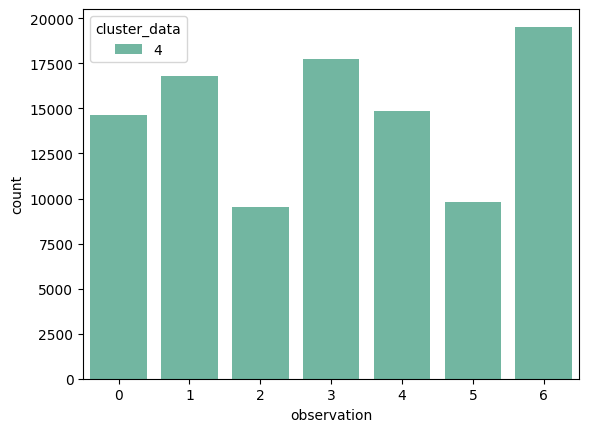

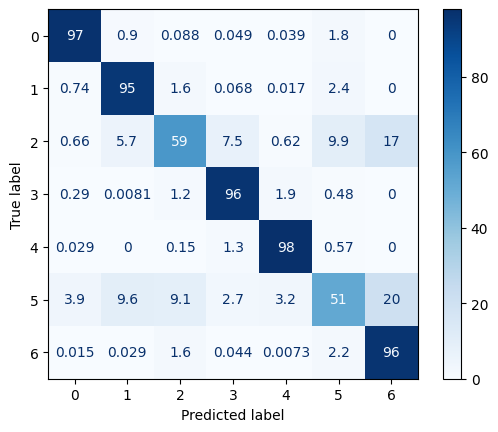

{'average_accuracy': 0.8806004019970174, 'average_f1_macro': np.float64(0.8425227832329877), 'average_f1_micro': np.float64(0.8806004019970174), 'average_auc': np.float64(0.9687906616187553), 'average_acc_kelas_generatif': 0.9575021102848216, 'average_acc_fase_padi': 0.896018325336111}
{'val_accuracy': 0.8867940257033692, 'val_f1_macro': np.float64(0.8515421996734858), 'val_f1_micro': np.float64(0.8867940257033692), 'val_auc': np.float64(0.9726160212831158), 'val_acc_kelas_generatif': 0.9616376531270149, 'val_acc_fase_padi': 0.9030535462886548, 'val_relative_acc': np.float64(96.46933664309935)}
CLUSTER:  5


[I 2024-10-16 09:34:42,590] A new study created in memory with name: no-name-6107664e-a2f1-4e8f-b911-40b56cb98a07


[6 1 5 4 2 3 0]
[0 1 2 3 4 5 6]
Mapping of original to encoded classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6)}
Build Best Parameter using Optuna-Hyperparameter Tuning


[I 2024-10-16 09:35:29,762] Trial 0 finished with value: 0.7441126883865187 and parameters: {'max_depth': 8, 'learning_rate': 0.05380518584332537, 'reg_lambda': 2.4121034874097624, 'min_child_weight': 81}. Best is trial 0 with value: 0.7441126883865187.


[I 2024-10-16 09:36:03,298] Trial 1 finished with value: 0.744666546023515 and parameters: {'max_depth': 10, 'learning_rate': 0.07863614624219033, 'reg_lambda': 2.9664654473927365, 'min_child_weight': 92}. Best is trial 1 with value: 0.744666546023515.


[I 2024-10-16 09:36:43,480] Trial 2 finished with value: 0.7443127801548034 and parameters: {'max_depth': 10, 'learning_rate': 0.054625849753358775, 'reg_lambda': 4.982132155253181, 'min_child_weight': 57}. Best is trial 1 with value: 0.744666546023515.


[I 2024-10-16 09:37:25,177] Trial 3 finished with value: 0.7436946207392618 and parameters: {'max_depth': 8, 'learning_rate': 0.07092074812269425, 'reg_lambda': 3.677473130838876, 'min_child_weight': 71}. Best is trial 1 with value: 0.744666546023515.


[I 2024-10-16 09:38:21,940] Trial 4 finished with value: 0.7407885818303427 and parameters: {'max_depth': 7, 'learning_rate': 0.04157489811524897, 'reg_lambda': 0.6978204459453035, 'min_child_weight': 74}. Best is trial 1 with value: 0.744666546023515.


[I 2024-10-16 09:39:53,990] Trial 5 finished with value: 0.7455430473664378 and parameters: {'max_depth': 9, 'learning_rate': 0.030679517786405604, 'reg_lambda': 0.30773133182560314, 'min_child_weight': 91}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:40:36,273] Trial 6 finished with value: 0.7437656145346372 and parameters: {'max_depth': 9, 'learning_rate': 0.08173613881437329, 'reg_lambda': 4.862522047566305, 'min_child_weight': 54}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:41:25,171] Trial 7 finished with value: 0.7448847048317863 and parameters: {'max_depth': 10, 'learning_rate': 0.0503173946227212, 'reg_lambda': 1.9128633149876502, 'min_child_weight': 93}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:42:05,866] Trial 8 finished with value: 0.7418681460925529 and parameters: {'max_depth': 6, 'learning_rate': 0.07055268600578064, 'reg_lambda': 4.863511466778397, 'min_child_weight': 69}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:43:12,939] Trial 9 finished with value: 0.7428782956831558 and parameters: {'max_depth': 6, 'learning_rate': 0.043912573971774914, 'reg_lambda': 1.3288043809298553, 'min_child_weight': 83}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:45:04,022] Trial 10 finished with value: 0.7427663182179431 and parameters: {'max_depth': 8, 'learning_rate': 0.014996350954673714, 'reg_lambda': 0.12479074849381805, 'min_child_weight': 98}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:47:10,971] Trial 11 finished with value: 0.7452293500231458 and parameters: {'max_depth': 9, 'learning_rate': 0.01982451752510614, 'reg_lambda': 1.6203007716790472, 'min_child_weight': 92}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:49:07,354] Trial 12 finished with value: 0.7450044702651543 and parameters: {'max_depth': 9, 'learning_rate': 0.02099066124549879, 'reg_lambda': 1.0213305375694017, 'min_child_weight': 86}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:50:31,235] Trial 13 finished with value: 0.7446723440836709 and parameters: {'max_depth': 9, 'learning_rate': 0.029052738247113262, 'reg_lambda': 0.1319007351166234, 'min_child_weight': 96}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:51:30,555] Trial 14 finished with value: 0.7430869145730982 and parameters: {'max_depth': 9, 'learning_rate': 0.033610771027503046, 'reg_lambda': 1.6647707215608438, 'min_child_weight': 88}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:54:01,399] Trial 15 finished with value: 0.7433915006087822 and parameters: {'max_depth': 8, 'learning_rate': 0.013026778516291717, 'reg_lambda': 0.7507041619826134, 'min_child_weight': 64}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:55:27,796] Trial 16 finished with value: 0.7423361577998268 and parameters: {'max_depth': 7, 'learning_rate': 0.027861894586636588, 'reg_lambda': 2.3107940026394482, 'min_child_weight': 100}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:56:35,972] Trial 17 finished with value: 0.7434937197443912 and parameters: {'max_depth': 9, 'learning_rate': 0.03665424488683604, 'reg_lambda': 3.156213981353133, 'min_child_weight': 79}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:57:56,737] Trial 18 finished with value: 0.7428887756068338 and parameters: {'max_depth': 7, 'learning_rate': 0.023247792488730136, 'reg_lambda': 1.5751348208856912, 'min_child_weight': 89}. Best is trial 5 with value: 0.7455430473664378.


[I 2024-10-16 09:58:28,319] Trial 19 finished with value: 0.7445026338957988 and parameters: {'max_depth': 10, 'learning_rate': 0.09435586971766696, 'reg_lambda': 0.7209733034986607, 'min_child_weight': 79}. Best is trial 5 with value: 0.7455430473664378.


Best Parameters: {'max_depth': 9, 'learning_rate': 0.030679517786405604, 'reg_lambda': 0.30773133182560314, 'min_child_weight': 91}
Best Score: 0.7455430473664378
Start the modelling


[0]	train-mlogloss:1.89046	eval-mlogloss:1.88952


[100]	train-mlogloss:0.56561	eval-mlogloss:0.68055


[200]	train-mlogloss:0.39435	eval-mlogloss:0.58198


[300]	train-mlogloss:0.31838	eval-mlogloss:0.55902


[400]	train-mlogloss:0.26159	eval-mlogloss:0.55011


[500]	train-mlogloss:0.21760	eval-mlogloss:0.54696


[600]	train-mlogloss:0.18395	eval-mlogloss:0.54636


[700]	train-mlogloss:0.15521	eval-mlogloss:0.54733


[800]	train-mlogloss:0.13349	eval-mlogloss:0.54984


[900]	train-mlogloss:0.11737	eval-mlogloss:0.55288


[1000]	train-mlogloss:0.10312	eval-mlogloss:0.55658


[1100]	train-mlogloss:0.09213	eval-mlogloss:0.56019


[1200]	train-mlogloss:0.08261	eval-mlogloss:0.56431


[1300]	train-mlogloss:0.07412	eval-mlogloss:0.56825


[1400]	train-mlogloss:0.06741	eval-mlogloss:0.57209


[1500]	train-mlogloss:0.06159	eval-mlogloss:0.57609


[1600]	train-mlogloss:0.05708	eval-mlogloss:0.57979


[1621]	train-mlogloss:0.05621	eval-mlogloss:0.58067


[0]	train-mlogloss:1.89073	eval-mlogloss:1.88948


[100]	train-mlogloss:0.57589	eval-mlogloss:0.68005


[200]	train-mlogloss:0.40264	eval-mlogloss:0.57852


[300]	train-mlogloss:0.32924	eval-mlogloss:0.55470


[400]	train-mlogloss:0.27462	eval-mlogloss:0.54502


[500]	train-mlogloss:0.22972	eval-mlogloss:0.54027


[600]	train-mlogloss:0.19413	eval-mlogloss:0.53774


[700]	train-mlogloss:0.16375	eval-mlogloss:0.53682


[800]	train-mlogloss:0.14042	eval-mlogloss:0.53742


[900]	train-mlogloss:0.12210	eval-mlogloss:0.53891


[1000]	train-mlogloss:0.10811	eval-mlogloss:0.54114


[1100]	train-mlogloss:0.09536	eval-mlogloss:0.54414


[1200]	train-mlogloss:0.08611	eval-mlogloss:0.54742


[1300]	train-mlogloss:0.07740	eval-mlogloss:0.55119


[1400]	train-mlogloss:0.07038	eval-mlogloss:0.55429


[1500]	train-mlogloss:0.06499	eval-mlogloss:0.55754


[1600]	train-mlogloss:0.06014	eval-mlogloss:0.56076


[1700]	train-mlogloss:0.05564	eval-mlogloss:0.56400


[1703]	train-mlogloss:0.05553	eval-mlogloss:0.56405


[0]	train-mlogloss:1.88988	eval-mlogloss:1.88901


[100]	train-mlogloss:0.55916	eval-mlogloss:0.68297


[200]	train-mlogloss:0.39578	eval-mlogloss:0.58193


[300]	train-mlogloss:0.32010	eval-mlogloss:0.55909


[400]	train-mlogloss:0.26431	eval-mlogloss:0.55016


[500]	train-mlogloss:0.21902	eval-mlogloss:0.54631


[600]	train-mlogloss:0.18343	eval-mlogloss:0.54543


[700]	train-mlogloss:0.15504	eval-mlogloss:0.54666


[800]	train-mlogloss:0.13227	eval-mlogloss:0.54877


[900]	train-mlogloss:0.11579	eval-mlogloss:0.55192


[1000]	train-mlogloss:0.10064	eval-mlogloss:0.55573


[1100]	train-mlogloss:0.08915	eval-mlogloss:0.55988


[1200]	train-mlogloss:0.08001	eval-mlogloss:0.56425


[1300]	train-mlogloss:0.07288	eval-mlogloss:0.56815


[1400]	train-mlogloss:0.06602	eval-mlogloss:0.57252


[1500]	train-mlogloss:0.06059	eval-mlogloss:0.57696


[1584]	train-mlogloss:0.05663	eval-mlogloss:0.58058


[0]	train-mlogloss:1.89000	eval-mlogloss:1.88814


[50]	train-mlogloss:0.84805	eval-mlogloss:0.87374


[100]	train-mlogloss:0.58495	eval-mlogloss:0.65841


[150]	train-mlogloss:0.47843	eval-mlogloss:0.58700


[200]	train-mlogloss:0.42435	eval-mlogloss:0.55777


[250]	train-mlogloss:0.38867	eval-mlogloss:0.54343


[300]	train-mlogloss:0.35765	eval-mlogloss:0.53458


[350]	train-mlogloss:0.33236	eval-mlogloss:0.52897


[400]	train-mlogloss:0.31010	eval-mlogloss:0.52436


[450]	train-mlogloss:0.28861	eval-mlogloss:0.52092


[500]	train-mlogloss:0.26825	eval-mlogloss:0.51811


[550]	train-mlogloss:0.24953	eval-mlogloss:0.51600


[600]	train-mlogloss:0.23159	eval-mlogloss:0.51418


[650]	train-mlogloss:0.21628	eval-mlogloss:0.51322


[700]	train-mlogloss:0.20210	eval-mlogloss:0.51244


[750]	train-mlogloss:0.18817	eval-mlogloss:0.51205


[800]	train-mlogloss:0.17535	eval-mlogloss:0.51185


[850]	train-mlogloss:0.16338	eval-mlogloss:0.51189


[881]	train-mlogloss:0.15559	eval-mlogloss:0.51206



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.63      0.53      0.57      6866
           1       0.90      0.93      0.92     12250
           2       0.96      0.99      0.97     11409
           3       0.95      0.97      0.96     12447
           4       0.59      0.50      0.54      6891
           5       0.55      0.45      0.50      6805
           6       0.79      0.95      0.87     13458

    accuracy                           0.82     70126
   macro avg       0.77      0.76      0.76     70126
weighted avg       0.81      0.82      0.81     70126



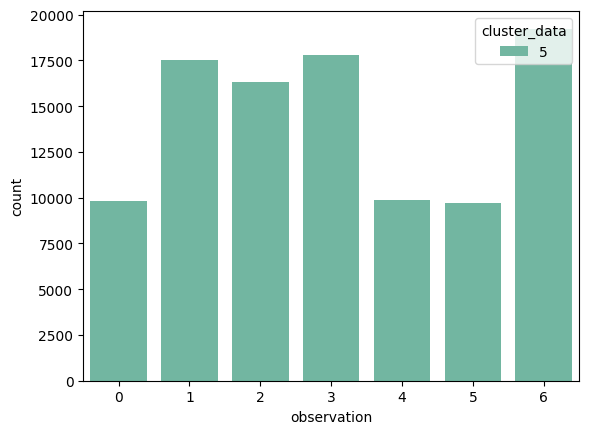

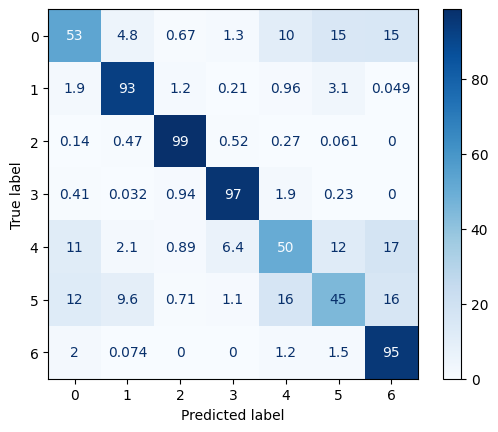

{'average_accuracy': 0.8096093698010248, 'average_f1_macro': np.float64(0.7456920957130452), 'average_f1_micro': np.float64(0.8096093698010248), 'average_auc': np.float64(0.9474084199947095), 'average_acc_kelas_generatif': 0.964386724003513, 'average_acc_fase_padi': 0.8777404738426099}
{'val_accuracy': 0.8204945384023045, 'val_f1_macro': np.float64(0.7605025996768938), 'val_f1_micro': np.float64(0.8204945384023045), 'val_auc': np.float64(0.9528175874457043), 'val_acc_kelas_generatif': 0.965212501004258, 'val_acc_fase_padi': 0.8849687187478196, 'val_relative_acc': np.float64(98.80808921802765)}


In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
df['observation']=df['observation'].apply(lambda y: int(y))
dict_report={}
for i in np.sort(df.cluster_data.unique()):
    print('=============================================================================')
    print('CLUSTER: ', i)
    df_x = df.query('cluster_data==@i')
    sns.countplot(x='observation', hue='cluster_data', data=df_x,palette=sns.color_palette("Set2"))
    plt.savefig(f"/data/ksa/05_Modelling/picture/{kdprov}_distplot_cluster_{i}.png", dpi=300, bbox_inches='tight')
    X_train, X_test, y_train, y_test = get_train_test(df_x, 0.7)
    # Encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # Output the unique encoded labels and the mapping
    print(np.unique(y_train_encoded))
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print("Mapping of original to encoded classes:", class_mapping)
    
    # Create an Optuna study and optimize the objective function
    print('Build Best Parameter using Optuna-Hyperparameter Tuning')
    study = optuna.create_study(direction='maximize')  # 'maximize' because we are optimizing accuracy
    study.optimize(lambda trial: objective(trial, X_train, y_train_encoded), n_trials=20)  # Run for 50 trials
    # Print the best parameters and the best score
    print(f"Best Parameters: {study.best_params}")
    print(f"Best Score: {study.best_value}")

    print('Start the modelling')
    model0, training_metrics0, validation_metrics0, report0, cm0 = evaluate_model(
        X_train, y_train_encoded, X_test, y_test_encoded,cluster=i,best_params=study.best_params)
    
    dict_report[i]={'model':model0,
                    'training_metrics':training_metrics0,
                    'validation_metrics':validation_metrics0,
                    'reports':report0,
                    'cm':cm0,
                    'params':study.best_params}
    # Print the training and validation metrics
    print(training_metrics0)
    print(validation_metrics0)
    print('=============================================================================')




In [11]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl','wb') as file:
    pickle.dump(dict_report,file)